<H1>Import libraries</H1>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle

<H1>Load the Dataset</H1>

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,bg,размерът на хоризонталната мрежа може да бъде ...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .
...,...,...
69995,ja,本格的なゲーミングヘッドホンでした。 今まで使ってた1万円するパナソニックのヘッドホンは何だ...
69996,el,"Ναι , ξέρω ένα που είναι ακόμα έτσι , αλλά αυτ..."
69997,ur,اور مجھے اس ملک کے بارے میں معلوم نہیں ہے کہ گ...
69998,es,Se me rompió uno al sacarlo del cargador. Cali...


<H1>EDA</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  70000 non-null  object
 1   text    70000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

labels    0
text      0
dtype: int64

In [6]:
df.describe()

,labels,text
count,70000,70000
unique,20,68978
top,pt,Een man speelt gitaar.
freq,3500,18


In [7]:
labels = df['labels'].unique()
labels

array(['pt', 'bg', 'zh', 'th', 'ru', 'pl', 'ur', 'sw', 'tr', 'es', 'ar',
       'it', 'hi', 'de', 'el', 'nl', 'fr', 'vi', 'en', 'ja'], dtype=object)

<H1> Data Transformation </H1>

In [8]:
df['labels'] = df['labels'].map(lambda x:1 if x == 'en' else 0)

In [9]:
df.head()

,labels,text
0,0,"os chefes de defesa da estónia, letónia, lituâ..."
1,0,размерът на хоризонталната мрежа може да бъде ...
2,0,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,0,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,0,Он увеличил давление .


In [10]:
samples_per_label = 7000 // df['labels'].nunique()

df_balanced = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(n=min(len(x), samples_per_label), random_state=42))

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['labels'].value_counts())
print("New dataset size:", len(df_balanced))

labels
1    3500
0    3500
Name: count, dtype: int64
New dataset size: 7000


C:\Users\raiom.LAPTOP-59QT21KS\AppData\Local\Temp\ipykernel_24784\123823128.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(n=min(len(x), samples_per_label), random_state=42))


In [11]:
pattern = r'[!@#$(),\n"%^*?\:;~0-9\[\]]'

df_balanced['text'] = (
    df_balanced['text']
    .str.replace(pattern, ' ', regex=True)
    .str.lower()                          
    .str.strip()                          
)


In [12]:
print(df_balanced['text'][0:5])

0    product good  paid to much for   day delivery ...
1    de cwa  die meer dan  .    comcast-werknemers ...
2    من بين ال     فصيلة الحيوانية التي عثر عليها ف...
3    crema de afeitar de fácil aplicación y con una...
4    great switches if you know you have a common w...
Name: text, dtype: object


In [13]:
X = df_balanced['text']
Y = df_balanced['labels']

<H1>Data Preparation </H1>

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [15]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

In [16]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

<H1>Model Initialization</H1>

In [17]:
model_langid = MultinomialNB()

In [18]:
model_langid.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [19]:
model_langid.fit(X_train, Y_train)

MultinomialNB()

In [20]:
Y_pred = model_langid.predict(X_train)
Y_prob = model_langid.predict_proba(X_train)[:, 1]

In [21]:
y_pred = model_langid.predict(X_test)
y_prob = model_langid.predict_proba(X_test)[:, 1]

In [22]:
p = precision_score(Y_train, Y_pred)
r = recall_score(Y_train, Y_pred)
rocauc = roc_auc_score(Y_train, Y_prob)

In [23]:
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_prob)

In [24]:
print(f'Precision: {p:.4f}')
print(f'Recall: {r:.4f}')
print(f'ROC-AUC Score: {rocauc:.4f}')

Precision: 0.7948
Recall: 1.0000
ROC-AUC Score: 0.9999


In [25]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')

Precision: 0.8011
Recall: 1.0000
ROC-AUC Score: 0.9999


In [26]:
ac_train = accuracy_score(Y_train, Y_pred)
cm_train = confusion_matrix(Y_train, Y_pred)
cr_train = classification_report(Y_train, Y_pred, zero_division=0)

print("Accuracy:", ac_train)
print("Confusion Matrix:\n", cm_train)
print("Classification Report:\n", cr_train)

Accuracy: 0.8718367346938776
Confusion Matrix:
 [[1839  628]
 [   0 2433]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.85      2467
           1       0.79      1.00      0.89      2433

    accuracy                           0.87      4900
   macro avg       0.90      0.87      0.87      4900
weighted avg       0.90      0.87      0.87      4900



Accuracy: 0.8738095238095238
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85      1033
           1       0.80      1.00      0.89      1067

    accuracy                           0.87      2100
   macro avg       0.90      0.87      0.87      2100
weighted avg       0.90      0.87      0.87      2100



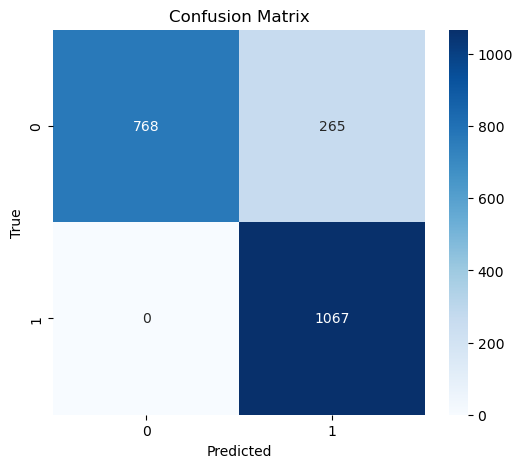

In [27]:
ac = accuracy_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)
cr = classification_report(Y_test, y_pred, zero_division=0)

print("Accuracy:", ac)
print("Classification Report:\n", cr)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
with open('utils/vectors/tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

In [29]:
with open('utils/models/langid_model.pkl', 'wb') as lang_id:
    pickle.dump(model_langid, lang_id)